In [34]:
import pandas as pd

def extract_text_from_csv(csv_file_path, start_column, end_column):
    df = pd.read_csv(csv_file_path)
    selected_columns = df.iloc[:, start_column-1:end_column]
    text_list = selected_columns.values.flatten().tolist()

    return text_list

csv_file_path = '/Users/caiyuanxiaodangao/Desktop/CENLP_final/output.csv'
start_column = 2  
end_column = 401  

text_list = extract_text_from_csv(csv_file_path, start_column, end_column)

labels = text_list[::2]

sentence_list = text_list[1::2]

sentence_list[:5]

['Presents a good case while failing to provide a reason for us to care beyond the very basic dictums of human decency.',
 'Beautifully crafted, engaging filmmaking that should attract upscale audiences hungry for quality and a nostalgic, twisty yarn that will keep them guessing.',
 'Bread, My Sweet has so many flaws it would be easy for critics to shred it.',
 'Slow, silly and unintentionally hilarious.',
 'Ultimately feels empty and unsatisfying, like swallowing a Communion wafer without the wine.']

In [35]:
import torch
import torch.nn as nn
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification, BertTokenizerFast, BertModel

model_name = 'bert-base-uncased'
tokenizer = BertTokenizerFast.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
embedding_layer = model.embeddings.word_embeddings


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [36]:
# manually add CLS and SEP

########## The code below is from 'session04_intro-tokenization-transformers.ipynb' until the next dividing line.###################

sentence_list = ['[CLS] ' + instance + ' [SEP]' for instance in sentence_list]
print(sentence_list)

['[CLS] Presents a good case while failing to provide a reason for us to care beyond the very basic dictums of human decency. [SEP]', '[CLS] Beautifully crafted, engaging filmmaking that should attract upscale audiences hungry for quality and a nostalgic, twisty yarn that will keep them guessing. [SEP]', '[CLS] Bread, My Sweet has so many flaws it would be easy for critics to shred it. [SEP]', '[CLS] Slow, silly and unintentionally hilarious. [SEP]', '[CLS] Ultimately feels empty and unsatisfying, like swallowing a Communion wafer without the wine. [SEP]', '[CLS] Exudes the fizz of a Busby Berkeley musical and the visceral excitement of a sports extravaganza. [SEP]', "[CLS] The film rehashes several old themes and is capped with pointless extremes -- it's insanely violent and very graphic. [SEP]", '[CLS] Ryan Gosling is, in a word, brilliant as the conflicted Daniel. [SEP]', "[CLS] If Deuces Wild had been tweaked up a notch it would have become a camp adventure, one of those movies tha

In [37]:
from typing import List, Tuple, Dict, Union

def tokenize_data_new(
    tokenizer: BertTokenizer, 
    data: List[str],
    max_length: int = 60,
    add_special_tokens: bool = True,
    return_attention_mask: bool = True,
    truncation: bool = True,
    padding: Union[str, bool] = 'max_length',
) -> Tuple[torch.tensor, torch.tensor, List[List[int]]]:
    
    input_ids, input_mask, word_ids = list(), list(), list()
    
    for instance in data:
        encoded = tokenizer.encode_plus(
            instance,
            add_special_tokens=add_special_tokens,  
            padding=padding,
            max_length=max_length,
            truncation=True,
            return_attention_mask=return_attention_mask,  
        )
        input_ids.append(encoded['input_ids'])
        input_mask.append(encoded['attention_mask'])
        word_ids.append(encoded.word_ids())

    # convert list of lists into tensor
    input_ids = torch.tensor(input_ids)
    input_mask = torch.tensor(input_mask)
    
    # the word ids first have to be converted to np array bc of the Nones
    word_ids = torch.tensor(np.array(word_ids, dtype=np.float32))
    
    return input_ids, input_mask, word_ids

In [38]:
batch_size = len(sentence_list)
max_length = 45

In [39]:
# tokenize the data
sentence_input_ids, sentence_mask, sentence_word_ids = tokenize_data_new(
    tokenizer=tokenizer,
    data=sentence_list,
    max_length=max_length,
    add_special_tokens=False,  # because we already added them to our sentence strings
)

In [40]:
print('input ids: ')
print(sentence_input_ids)
print('\nattention mask: ')
print(sentence_mask)
print('\nword ids:')
print(sentence_word_ids)

input ids: 
tensor([[  101,  7534,  1037,  ...,     0,     0,     0],
        [  101, 17950, 19275,  ...,     0,     0,     0],
        [  101,  7852,  1010,  ...,     0,     0,     0],
        ...,
        [  101,  2009,  1005,  ...,     0,     0,     0],
        [  101,  2273,  1999,  ...,     0,     0,     0],
        [  101, 17216,  4152,  ...,     0,     0,     0]])

attention mask: 
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

word ids:
tensor([[0., 1., 2.,  ..., nan, nan, nan],
        [0., 1., 2.,  ..., nan, nan, nan],
        [0., 1., 2.,  ..., nan, nan, nan],
        ...,
        [0., 1., 2.,  ..., nan, nan, nan],
        [0., 1., 2.,  ..., nan, nan, nan],
        [0., 1., 2.,  ..., nan, nan, nan]])


In [41]:
original_mask_instance1 = sentence_mask[0]
original_input_ids_instance1 = sentence_input_ids[0]

In [42]:
# pipe the input ids through the embedding layer / get the pre-trained embeddings
sentence_emb = embedding_layer(sentence_input_ids)
print('shape of the embeddings: ', sentence_emb.shape)

shape of the embeddings:  torch.Size([400, 45, 768])


In [43]:
# the pooling function

def pooling_fn(
    batch: torch.Tensor,  # shape bsz x seq len x emb dim
    word_ids: List[List[int]],
    pool_method: str = 'avg',  # 'avg', 'sum'
) -> Tuple[torch.Tensor, torch.Tensor]:
    """ 
    Function that takes as input a batch (not a single instance) and pools the sub-words in 
    each instance to word-level. Either average or sum pooling.
    """
    # create an empty tensor to hold the merged embeddings, shape bsz x 0 x emb dim
    merged_emb = torch.empty(sentence_emb.shape[0], 0, sentence_emb.shape[2])
    
    max_length = batch.shape[1]  # the sequence length
    
    # iterate through all possible word ids
    for word_idx in range(max_length):
        
        # tensor of shape bsz x 1 x emb dim
        # contains True if the word id is the current word idx (that we are looking at), False otherwise
        # if a word was split into several sub-word tokens, all these sub-word tokens will consist of True
        # so we know which ones to merge together
        word_mask = (sentence_word_ids == word_idx).unsqueeze(2).repeat(1, 1, 768)  # bsz x seq len x emb dim 
        
        if pool_method == 'avg':
            # multiply the embeddings with the mask so only the subwords belonging to the same word (ID) remain
                # then average them
            pooled_word_emb = torch.mean(sentence_emb * word_mask, dim=1).unsqueeze(1)  # bsz x 1 x emb dim
            
        elif pool_method == 'sum':
            # multiply the embeddings with the mask so only the subwords belonging to the same word (ID) remain
                # then sum them
            pooled_word_emb = torch.sum(sentence_emb * word_mask, dim=1).unsqueeze(1)  # bsz x 1 x emb dim
            
        else:
            raise NotImplementedError('this kind of pooling has not been implemented.')
        
        # concatenate the pooled word embedding to the tensor containing all word embeddings for each sequence in the batch
        merged_emb = torch.cat([merged_emb, pooled_word_emb], dim=1)
      #  print(merged_emb.shape)
    
    # create the new attention mask, shape bsz x seq len
    attention_mask = torch.sum(merged_emb, 2).bool().int()
    
    return merged_emb, attention_mask

In [44]:
pooled_embeddings, pooled_mask = pooling_fn(
    batch=sentence_emb,
    word_ids=sentence_word_ids,
)

In [45]:
# the shape is still the same
# compare with original embeddings
print(sentence_emb.shape)
print(pooled_embeddings.shape)

torch.Size([400, 45, 768])
torch.Size([400, 45, 768])


In [46]:
# compare the first instance, where sub-word tokens were pooled into 1
subword_tokens_instance1 = tokenizer.convert_ids_to_tokens(original_input_ids_instance1)
words_instance1 = sentence_list[0].split() 
words_instance1 += ['[PAD]'] * (len(subword_tokens_instance1) - len(words_instance1))
pooled_mask_instance1 = pooled_mask[0]

for subword, orig_mask, word, new_mask in zip(
    subword_tokens_instance1, original_mask_instance1, words_instance1, pooled_mask_instance1,
):
    print(subword, orig_mask.item(), word, new_mask.item())

[CLS] 1 [CLS] 1
presents 1 Presents 1
a 1 a 1
good 1 good 1
case 1 case 1
while 1 while 1
failing 1 failing 1
to 1 to 1
provide 1 provide 1
a 1 a 1
reason 1 reason 1
for 1 for 1
us 1 us 1
to 1 to 1
care 1 care 1
beyond 1 beyond 1
the 1 the 1
very 1 very 1
basic 1 basic 1
di 1 dictums 1
##ctum 1 of 1
##s 1 human 1
of 1 decency. 1
human 1 [SEP] 1
dec 1 [PAD] 1
##ency 1 [PAD] 0
. 1 [PAD] 0
[SEP] 1 [PAD] 0
[PAD] 0 [PAD] 0
[PAD] 0 [PAD] 0
[PAD] 0 [PAD] 0
[PAD] 0 [PAD] 0
[PAD] 0 [PAD] 0
[PAD] 0 [PAD] 0
[PAD] 0 [PAD] 0
[PAD] 0 [PAD] 0
[PAD] 0 [PAD] 0
[PAD] 0 [PAD] 0
[PAD] 0 [PAD] 0
[PAD] 0 [PAD] 0
[PAD] 0 [PAD] 0
[PAD] 0 [PAD] 0
[PAD] 0 [PAD] 0
[PAD] 0 [PAD] 0
[PAD] 0 [PAD] 0


In [47]:
model_output = model(
    input_ids=sentence_input_ids,
    attention_mask=sentence_mask,
)

In [48]:
print(len(model_output))  # contains last hidden state and pooler output

2


In [49]:
pooler_output = model_output.pooler_output   # or model_output[1]
print(pooler_output.shape)  # CLS token of every instance in the batch

## pooler output at word level

################# The code above is from 'session04_intro-tokenization-transformers.ipynb' ###################

torch.Size([400, 768])


In [50]:
labels_tensor = torch.tensor(labels)

In [78]:
####
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

pooler_output_np = pooler_output.detach().numpy()
labels_np = labels_tensor.detach().numpy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pooler_output_np, labels_np, test_size=0.2, random_state=42)

# SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0)

# Train the SVM classifier
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
predictions = svm_classifier.predict(X_test)


# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))


Accuracy: 82.50%
Precision: 0.90
Recall: 0.87
F1 Score: 0.88


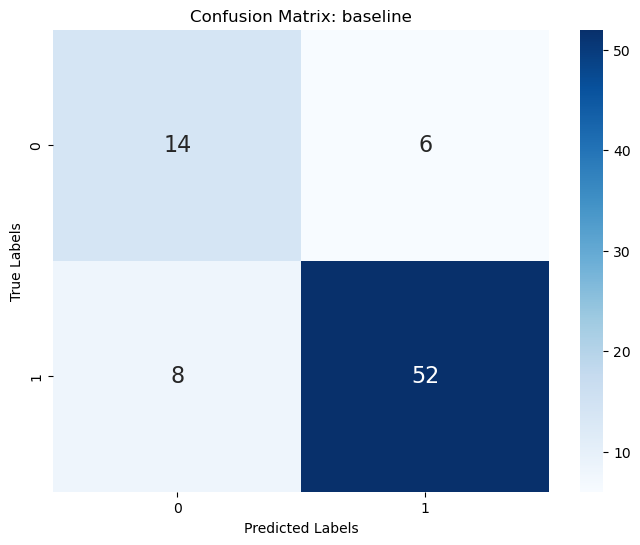

In [79]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predictions)

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.title("Confusion Matrix: baseline")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [72]:
import csv

filename = 'MFD.csv'
data = []

with open(filename, 'r', newline='', encoding='utf-8-sig') as csvfile:
    csvreader = csv.reader(csvfile)
    
    for row in csvreader:
        index, value = int(row[0]), int(row[1])
        data.append((index, value))

sum_dict = {}

for index, value in data:
    if index in sum_dict:
        sum_dict[index] += value
    else:
        sum_dict[index] = value

ET_data = list(sum_dict.values())

ET_tensor = torch.tensor(ET_data)

ET_tensor = ET_tensor.view(400, 1)

print(ET_tensor.shape)

torch.Size([400, 1])


In [73]:
new_pooler_output = torch.cat((pooler_output, ET_tensor), dim=1)
new_pooler_output.shape

torch.Size([400, 769])

In [80]:
####
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

new_pooler_output_np = new_pooler_output.detach().numpy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(new_pooler_output_np, labels_np, test_size=0.2, random_state=42)

# Initialize SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0)

# Train the SVM classifier
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
predictions = svm_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

Accuracy: 78.75%
Precision: 0.89
Recall: 0.82
F1 Score: 0.85


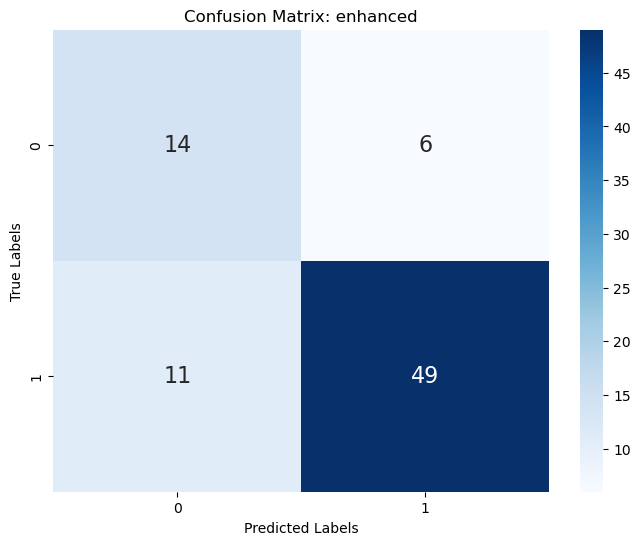

In [81]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predictions)

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.title("Confusion Matrix: enhanced")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
